<a href="" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

In October 2024, the city of Valencia (Spain) was hit by catastrophic flooding caused by intense storms, leaving over 230 deaths and billions in damages.<br>
This disaster was part of Europe’s worst flood year in over a decade, with hundreds of thousands affected continent-wide. Such events highlight the urgent need for reliable flood monitoring to support **emergency response**, damage assessment and long-term resilience planning.

**Sentinel-1 GDR** data is particularly valuable for this purpose.<br>
Its Synthetic Aperture Radar (SAR) can capture images day or night, in any weather, a feature especially important for flooding events, where cloudy and rainy weather can persist for weeks. This makes it far more reliable than optical sensors during storms.<br>
With its frequent revisits, wide coverage, and free high-resolution data, **Sentinel-1** enables the rapid mapping of flood extents, as will be demonstrated in this workflow.

<hr>

#### Import libraries

In [1]:
import xarray as xr 
import xarray_sentinel 
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

import dask                             # these last two libraries are imported to open the datasets faster
from dask.distributed import Client     # and in the end take advantage of the optimized .zarr format


/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


<hr>

## Data pre-processing

To search and load the data needed for the analysis, we will follow the processes we presented in [tutorial _]() and [tutorial _]().

Once we defined our interest Sentinel-1 GRD items, we can see that they contain both **VH** and **VV** polarizations.<br>
For this flood mapping context, **VV** polarization is the choice of interest, as water backscatter is much more visible with it, rather than with VH.

### Loading the datatree

The list below shows the names of the products we will use for the flood mapping and time series analysis.<br>
As we have seen in previous chapters, these names already contain valuable information that can be used to search for specific products within the [EOPF STAC catalogue]().

In [2]:
scenes = ["S1A_IW_GRDH_1SDV_20241007T180256_20241007T180321_056000_06D943_D46B", 
          "S1A_IW_GRDH_1SDV_20241019T180256_20241019T180321_056175_06E02E_2D52", 
          "S1A_IW_GRDH_1SDV_20241031T180256_20241031T180321_056350_06E71E_479F", 
          "S1A_IW_GRDH_1SDV_20241112T180255_20241112T180320_056525_06EE16_DC29", 
          "S1A_IW_GRDH_1SDV_20241124T180254_20241124T180319_056700_06F516_BA27", 
          "S1A_IW_GRDH_1SDV_20241206T180253_20241206T180318_056875_06FBFD_25AD", 
          "S1A_IW_GRDH_1SDV_20241218T180252_20241218T180317_057050_0702F2_0BC2", 
          "S1A_IW_GRDH_1SDV_20241230T180251_20241230T180316_057225_0709DD_15AC", 
          "S1A_IW_GRDH_1SDV_20250111T180250_20250111T180315_057400_0710C7_ADBB", 
          "S1A_IW_GRDH_1SDV_20250123T180249_20250123T180314_057575_0717B9_A784", 
          "S1A_IW_GRDH_1SDV_20250204T180249_20250204T180314_057750_071EA2_4373", 
          "S1A_IW_GRDH_1SDV_20250216T180248_20250216T180313_057925_0725AE_8AC7", 
          "S1A_IW_GRDH_1SDV_20250312T180248_20250312T180313_058275_0733E6_4F5B", 
          "S1A_IW_GRDH_1SDV_20250324T180248_20250324T180313_058450_073AD0_04B7", 
          ]

zarr_paths = []
for scene in scenes:
    zarr_paths.append(f"https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:notebook-data/tutorial_data/cpm_v260/{scene}.zarr")

Next, we will load all `zarr` datasets as data trees. Here **we are not reading** the entire dataset from the store; but, creating a set of references to the data, which enables us to access it efficiently later in the analysis.

In [3]:
client = Client()  # Set up local cluster on your laptop
client

@dask.delayed
def load_datatree_delayed(path):
    return xr.open_datatree(path, consolidated=True, chunks="auto")

# Create delayed objects
delayed_datatrees = [load_datatree_delayed(path) for path in zarr_paths]
# Compute in parallel
datatrees = dask.compute(*delayed_datatrees)

/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for

Each element inside the `datatree` list is a datatree and corresponds to a Sentinel-1 GRD scene datatree present on the list above.

In [4]:
# Each element inside the datatree list is a datatree and corresponds to a Sentinel-1 GRD scene datatree present on the list above
type(datatrees[0]) 

xarray.core.datatree.DataTree

### Defining variables

In [5]:
# Number of scenes we are working with for the time series analysis
DATASET_NUMBER = len(datatrees) 

If we run the following code line we will be able to see how each datatree is organized within its groups and subgroups (like seen on this [chapter](23_zarr_structure_S1GRD.ipynb)).<br>
From here, it was taken the groups `ID` constants seen on the following cell.<br>

Over the course of this notebook these `IDs` will be used to call variables and` compute some other functions.

In [6]:
# datatrees[0].groups

In [7]:
MEASUREMENTS_GROUP_ID = 7
GCP_GROUP_ID = 28
CALIBRATION_GROUP_ID = 33

We are also defining the thresholds that will be utilised for the flood mapping analysis. These values can be calibrated and adjusted to achieve a better fit.<br>

As water generally produces a positive backscatter response for values smaller than -15. (?)

In [8]:
WATER_THRESHOLD_DB = -15

It is interesting to study the flood event over a specific point within the area of interest.<br>
Therefore, we are storing the coordinates of an anchor point inside the area which is not usually covered by water. After the heavy rain, it became flooded for a few weeks.

In [9]:
TARGET_LAT = 39.28
TARGET_LONG = -0.30

## Extracting information from the `.zarr`

As explained in the [S1 basic operations tutorial](24_S1_basic_operations.ipynb), we will perform over all our dataset the following operations:

- Slicing the data to meet our area of interest and decimate it
- Assigning latitude and longitude coordinates to the dataset
- Computing the backscatter

### Slicing and decimating GRD variable

To begin with, we access all our `.zarr` items `measurements` groups by creating a list storing all of them.

In [10]:
measurements = []
# Looping to populate the measurements list with only the measurements groups of each dataset on the datatree list
for i in range(DATASET_NUMBER):
    measurements.append(datatrees[i][datatrees[i].groups[MEASUREMENTS_GROUP_ID]].to_dataset())

We continue by decimating `gdr`'s data. As we are only interested into a specific area (Valencia).

Because we haven't assigned latitude and longitude coordinates yet, we can not crop the data acording to coordinates. On top of this, even though different products have the same shape and dimensions (`azimuth_time` and `ground_range`), the values for the same indexes number don't match so either ways, it wouldn't be doable to slice the data acording to coordinate values (which would always be different for different products).

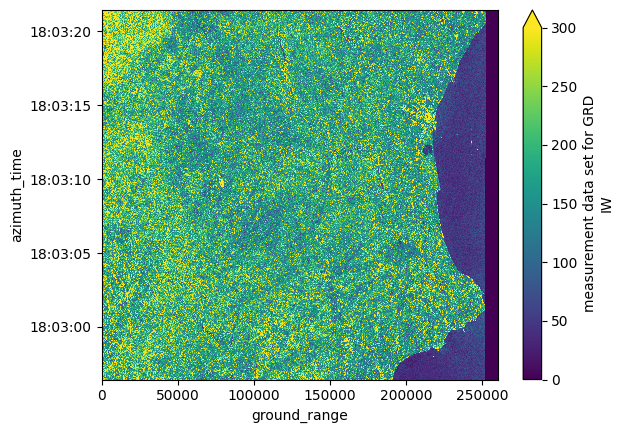

In [11]:
measurements[0].grd.isel(
        azimuth_time=slice(None, None, 20),
        ground_range=slice(None, None, 20)).plot(vmax=300)
plt.show()

In [12]:
print("Azimuth time has", measurements[0].grd.shape[0], "values.")
print("Ground range has", measurements[0].grd.shape[1], "values.")

Azimuth time has 16677 values.
Ground range has 26061 values.



The solution found is to slice the data by the coordinates index positon using `isel()` function. Just before, a rought plotting was done in order to visualize the whole image. it was also plotted the `azimuth_time` and `ground_range` shape. Considering the are we are interested, and after a few tests and direct proportion calculations, we see that we need:
- for `azimuth_time`, more or less from the last 10000 positions to the last 4500;
- for `ground_range`, more or less from the last 7000 positions to the last 2000;

In [13]:
grd = []
# Looping to populate the grd list with only the grd subgroups of each dataset on the 
# datatree list while simultaneaously slicing the data to match our AOI and decimating it
for i in range(DATASET_NUMBER):
    grd_group = measurements[i].grd
    azimuth_time_len = grd_group.sizes['azimuth_time']
    ground_range_len = grd_group.sizes['ground_range']
    
    grd.append(grd_group.isel(
        azimuth_time=slice((azimuth_time_len - 10000),    # beginning of the slice
                           (azimuth_time_len - 4500),     # end of the slice
                           10),                           # interval of the slice/decimation
        ground_range=slice((ground_range_len - 7000), 
                           (ground_range_len - 2000), 
                           10)
    ))

In [14]:
grd[1].shape

(550, 500)

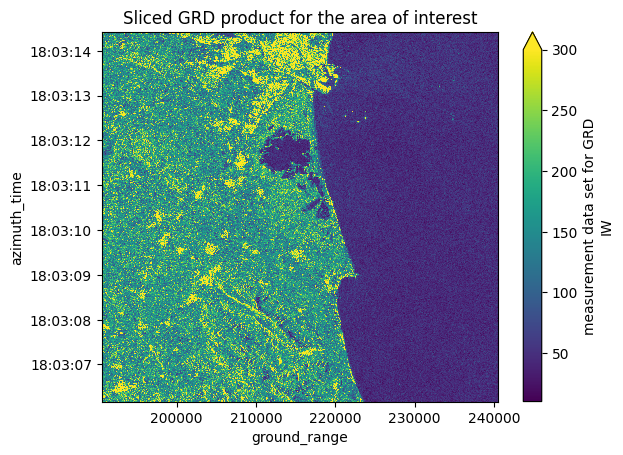

In [15]:
grd[1].plot(vmax=300)
plt.title("Sliced GRD product for the area of interest")
plt.show()

### Assigning latitude and longitude coordinates

The following steps will very similar to the ones done in the previous notebooks:
1. Creating a `gcp` dataset interpolated with the `grd` dataset;
2. Assigning the latitude and longitude coordinates to the `grd` dataset;

In [16]:
gcp = []
# Looping to populate the gcp list with only the gcp subgroups of each dataset on the datatree list
for i in range(DATASET_NUMBER):
    gcp.append(datatrees[i][datatrees[i].groups[GCP_GROUP_ID]].to_dataset())
    gcp[i] = gcp[i].interp_like(grd[i]) # interpolate gcp to match the decimation done before

In [17]:
# Looping to assign the latitude and longitude coordinates to grd 
for i in range(DATASET_NUMBER):
    grd[i] = grd[i].assign_coords({"latitude": gcp[i].latitude, 
                                   "longitude": gcp[i].longitude})

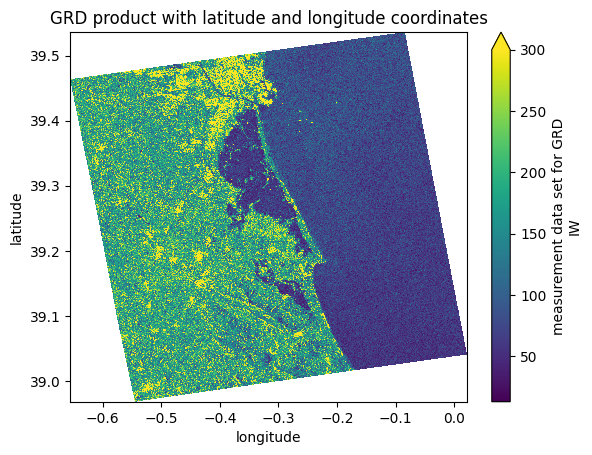

In [18]:
grd[2].plot(x="longitude", y="latitude", vmax=300)
plt.title("GRD product with latitude and longitude coordinates")
plt.show()

### Computing backscatter

Again, the following steps are just recreating what was done before, but this time over more datasets.

In [19]:
calibration = []
# Looping to populate the calibration list with only the calibration groups of each dataset on the datatree list
for i in range(DATASET_NUMBER):
    calibration.append(datatrees[i][datatrees[i].groups[CALIBRATION_GROUP_ID]].to_dataset())
    calibration[i] = calibration[i].interp_like(grd[i]) # interpolate calibration to match the decimation done before

In [20]:
intensity = []
# Looping to populate the intensity list with the calibrated intensity array originated from xarray_sentinel.calibrate_intensity function
for i in range(DATASET_NUMBER):
    intensity.append(xarray_sentinel.calibrate_intensity(
        grd[i], 
        calibration[i].beta_nought, 
        as_db=True))

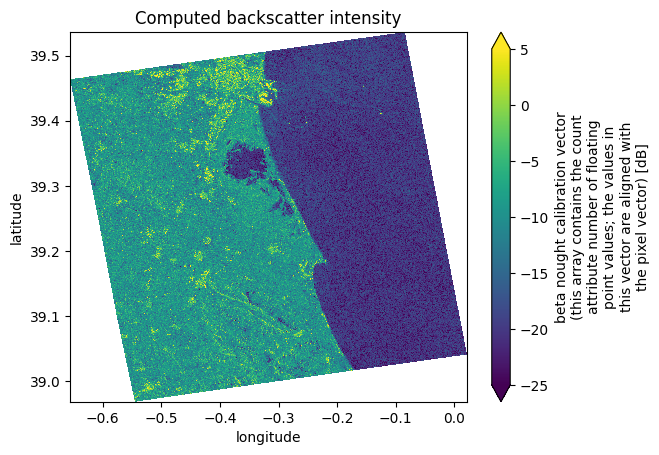

In [21]:
intensity[1].plot(x="longitude", y="latitude", vmin=-25, vmax=5)
plt.title("Computed backscatter intensity")
plt.show()

### Data cube array for the time series analysis

Since we are performing a time series with `.zarr`, instead of analysing individual items stored in a list, we can create a combined dataset, containing all the data we are dealing with, stacked by a new dimension `time`. This is known as a data cube.

To get values for the new dimension we will create, we need to extract the acquisiton dates for each product we want to stack into our data cube.

In [22]:
data = []
# Looping to populate the data list with all the acquisition dates from the datatree
for i in range(DATASET_NUMBER):
    data.append(intensity[i].azimuth_time.values[1].astype('datetime64[D]'))
data

[np.datetime64('2024-10-07'),
 np.datetime64('2024-10-19'),
 np.datetime64('2024-10-31'),
 np.datetime64('2024-11-12'),
 np.datetime64('2024-11-24'),
 np.datetime64('2024-12-06'),
 np.datetime64('2024-12-18'),
 np.datetime64('2024-12-30'),
 np.datetime64('2025-01-11'),
 np.datetime64('2025-01-23'),
 np.datetime64('2025-02-04'),
 np.datetime64('2025-02-16'),
 np.datetime64('2025-03-12'),
 np.datetime64('2025-03-24')]

The next step is sensitive. In order to stack data into an array, the dimension values need to match perfectly, which is not the case (Sentinel-1 GRD data dimension values differ from one product to the other).<br>
This problem resembles the **coregistrations** problem. This refers to the process of aligning two or more images, in a way that each pixel in one image corresponds to the exact same ground location in the others. To have a deeper overview of this process you can take a look [here](https://elisecolin.medium.com/what-is-coregistration-in-remote-sensing-7d76d48d337d).

There are only a few software programmes and packages that can perform coregistration, and most of the time, these processes are very time-consuming and resource-intensive.

Since the GRD images we are working with already have the same dimensions (cropped during the initial steps of the tutorial), we can perform our own coregistration. Such process involves:
- Keeping the coordinates of one `intensity` dataset as the reference
- Resetting the coordinates of the other ones
- Reassigning the coordinates to match the reference dataset and that they can all overlay perfectly.

To do so we will use `reset_coords()` to reset the original coordinates and then use the `assign_coords` functions as it follows.

In [23]:
reference_coords = intensity[0].coords # setting the first coordinate values as reference

datasets_aligned = []
# Looping to populate the datasets_aligned list with the newly assigned coordinate values
for ds in intensity:
    ds_no_coords = ds.reset_coords(drop=True)
    datasets_aligned.append(ds_no_coords.assign_coords(reference_coords))

Now, the data is fully prepared to be stacked into a new array that contains all the datasets we are studying, they share the same coordinate values and everything is organized by a third dimension, `time`. To stack all the datasets into only one we will use the `concat()` function from `xarray` library.

In [24]:
# Creating the data cube, stacking all the datasets over a new time dimension
intensity_data_cube = xr.concat(datasets_aligned, dim=xr.DataArray(data, dims="time"))

# There is a new dimension coordinate (time) 
intensity_data_cube

<xarray.DataArray (time: 14, azimuth_time: 550, ground_range: 500)> Size: 15MB
dask.array<concatenate, shape=(14, 550, 500), dtype=float32, chunksize=(1, 398, 500), chunktype=numpy.ndarray>
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 4kB 2024-10-07T18:03:06.46487...
  * ground_range  (ground_range) float64 4kB 1.906e+05 1.907e+05 ... 2.405e+05
    line          (azimuth_time) float64 4kB dask.array<chunksize=(550,), meta=np.ndarray>
    pixel         (ground_range) float64 4kB dask.array<chunksize=(500,), meta=np.ndarray>
    latitude      (azimuth_time, ground_range) float64 2MB dask.array<chunksize=(550, 500), meta=np.ndarray>
    longitude     (azimuth_time, ground_range) float64 2MB dask.array<chunksize=(550, 500), meta=np.ndarray>
  * time          (time) datetime64[s] 112B 2024-10-07 2024-10-19 ... 2025-03-24
Attributes:
    _eopf_attrs:  {'coordinates': ['azimuth_time', 'line', 'pixel', 'ground_r...
    dtype:        <u2
    long_name:    beta nought calibration vector (this array contains the cou...
    units:        dB

## Flood mapping and time series analysis

The last step is to perform the time series and flood mapping analysis.<br>

First, we can plot all the datasets simply to create a visual aid of the flood. In addition to these plots, we are also plotting a chosen latitude and longitude point (coordinates defined previously).<br>
The chosen point will serve as a measure of comparison between all the datasets and from within different analysis methods.<br>

When we look over all the items plotted, we can clearly see that the significant flood event happened between the 19th and the 31st of October (it occurred on the 29th of October 2024).<br>

As appreciated in our created visualisation, we can see that it was not until around mid-February 2025, the backscatter presented the water presence was goint back to normal.

/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_72038/3594274766.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


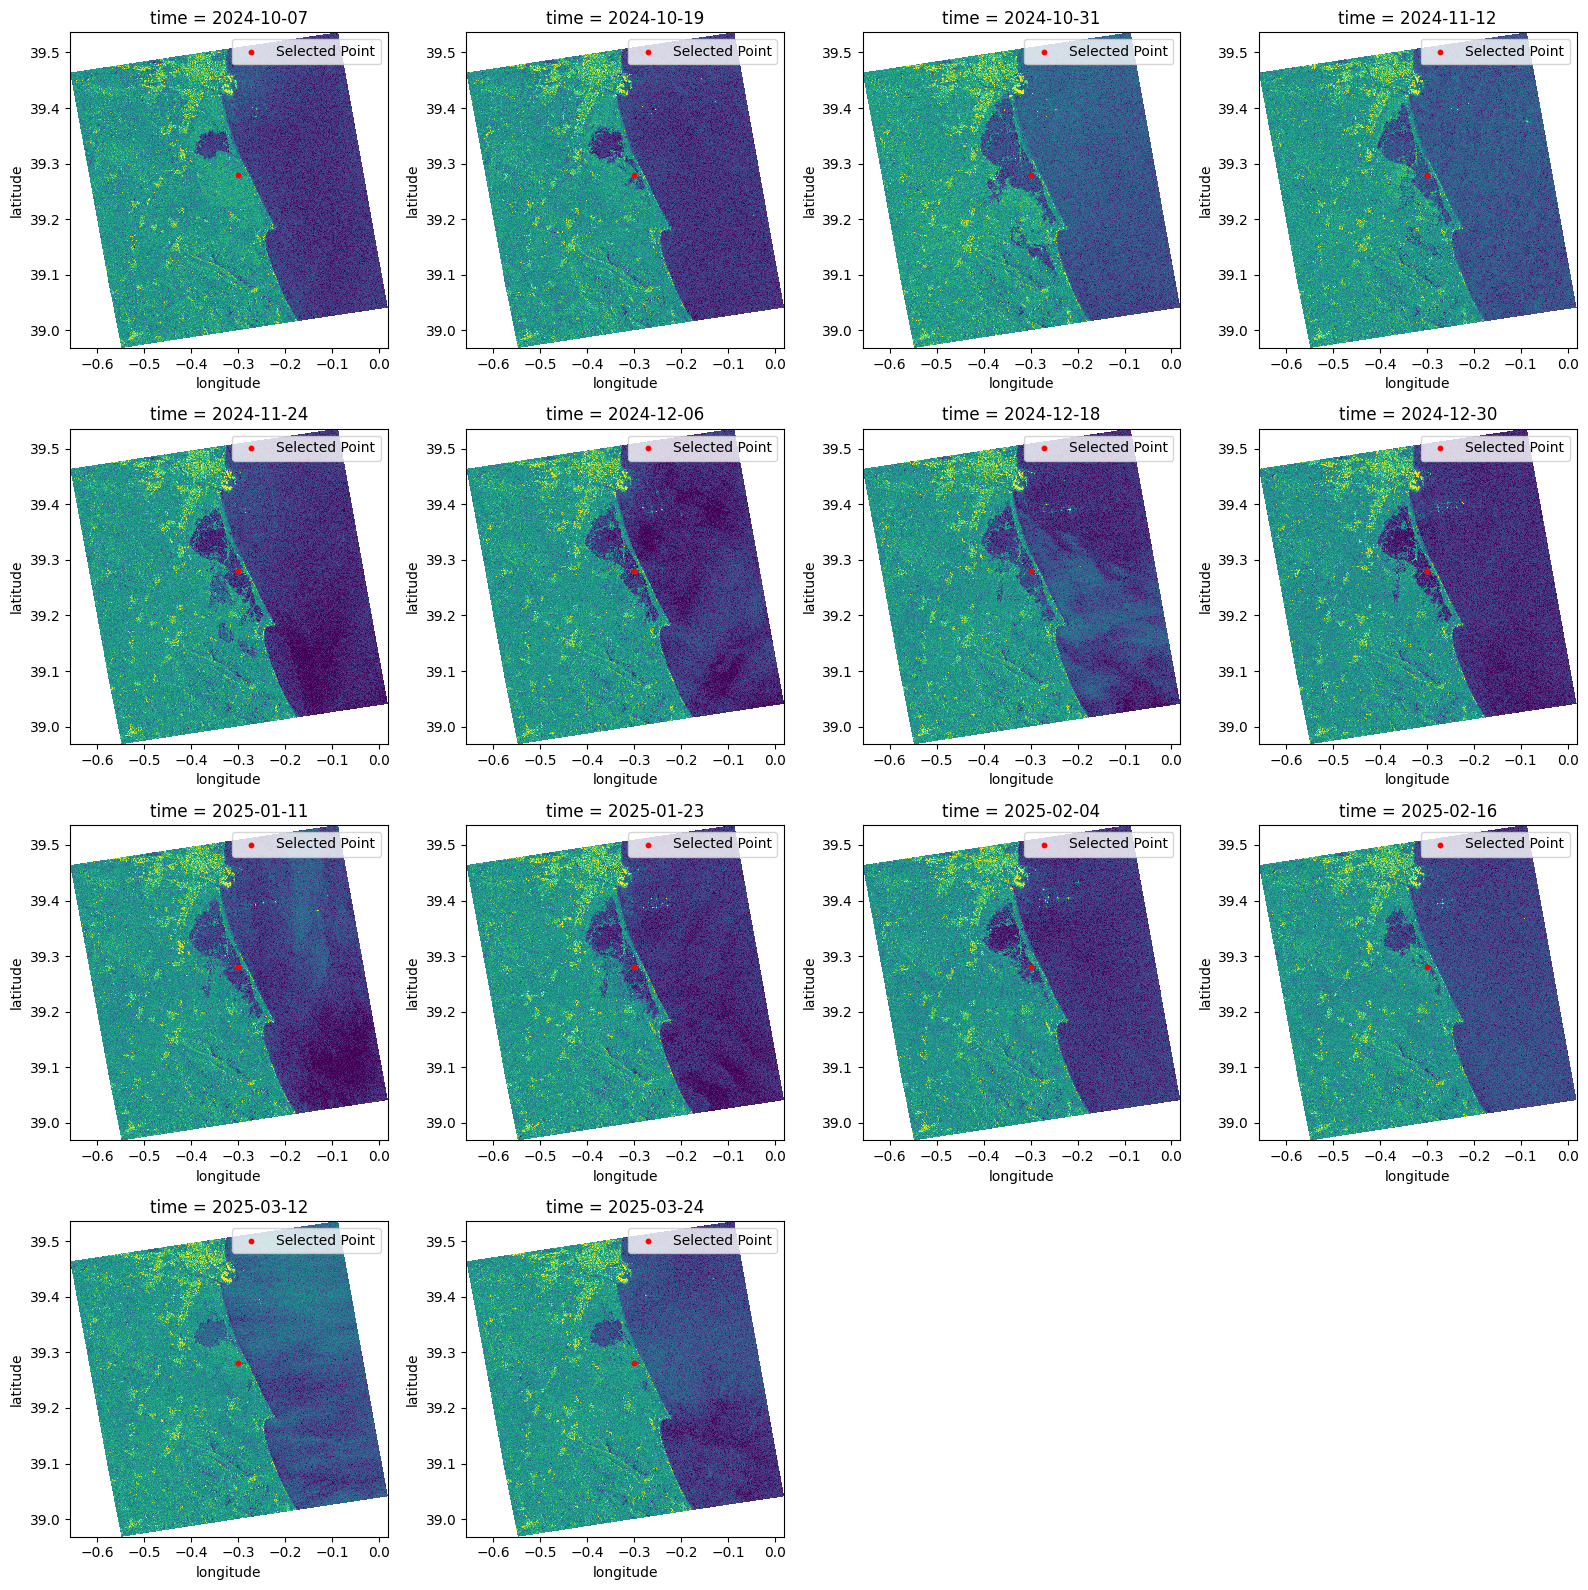

In [30]:
cols = 4    # setting up column number
rows = int(np.ceil(DATASET_NUMBER / cols))  # setting up row number according to clumn number
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))  
axes = axes.flatten()  

for i in range(DATASET_NUMBER):
    ax = axes[i]
    intensity_data_cube[i].plot(    # plotting all the datasets stored in the data cube
        x="longitude", y="latitude",
        vmin=-25, vmax=5,
        ax=ax,  
        add_colorbar=False  
    )
    ax.scatter(TARGET_LONG, TARGET_LAT, color="red", marker="o", s=10, label="Selected Point")  # also plotting the known point defined before
    ax.legend()

for j in range(i+1, len(axes)):
    axes[j].axis('off')     # to avoid having empty cells

plt.tight_layout()
plt.show()


Another interesting analysis to perform is a flood map based on threshold values.<br>
It is known through literature and other sources that water appears as darker pixels, typically with values lower than **-15 dB**. This is a very good method for identifying water because separating the pixels within this threshold value will give us almost a `True` and `False` map for pixels which are greater or smaller than the defined threshold.

In the plots below, we appreciate the pixels with backscatter values equal to or lower than -15 in yellow. Conversely, in purple, we see the pixels that have backscatter values greater than -15.<br>
Of course, there are always outlier values, but for the majority of the scene, it is possible to identify the flooded and non-flooded areas.

/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_72038/2202074428.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


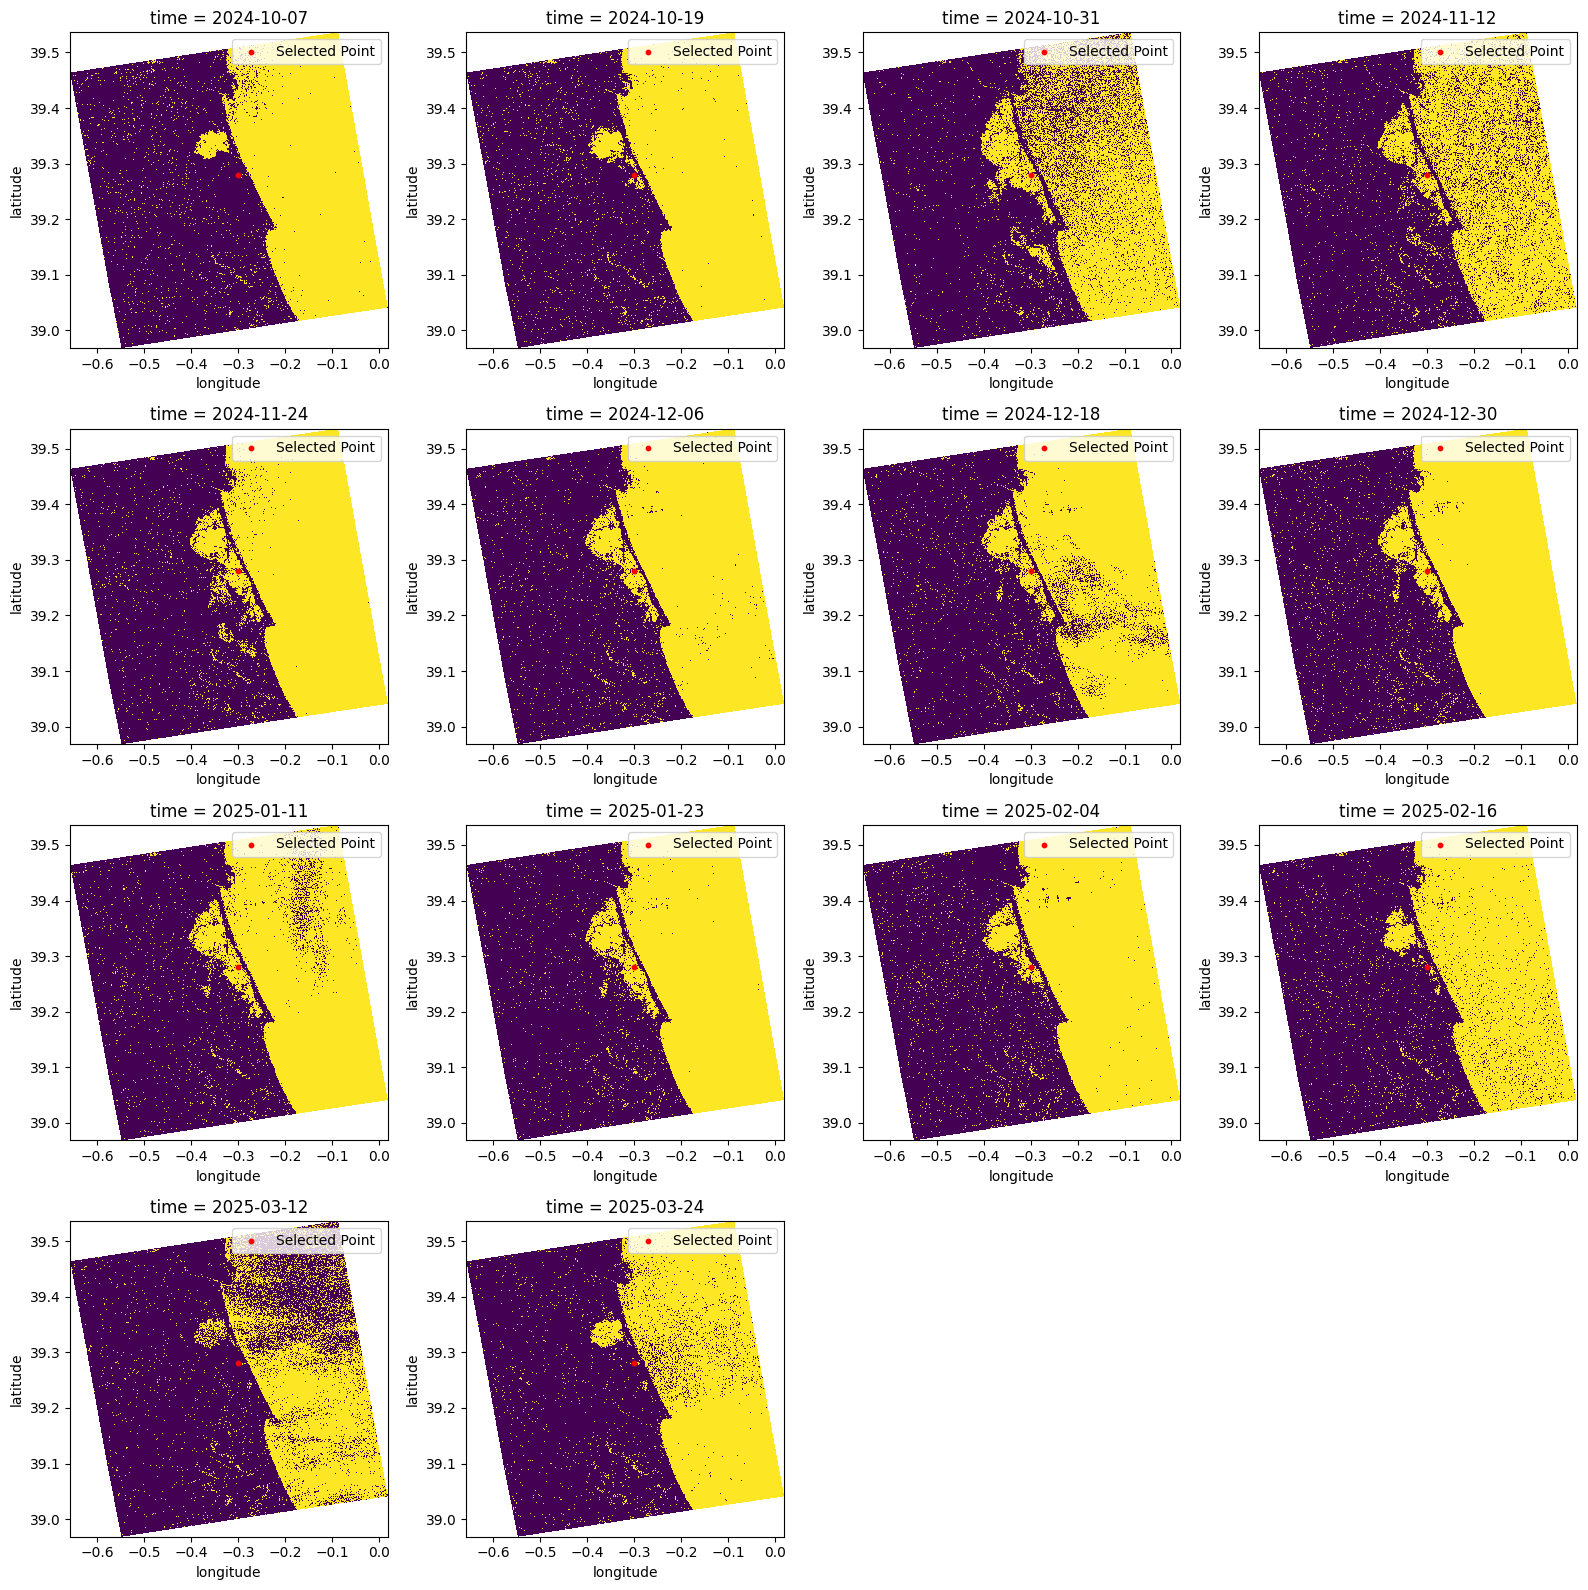

In [31]:
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))  
axes = axes.flatten()  

for i in range(DATASET_NUMBER):
    ax = axes[i]
    water_mask = (intensity_data_cube[i] <= WATER_THRESHOLD_DB)     # defining the water mask from the threshold
    water_mask.plot(        # plotting all the water masks 
        x="longitude", y="latitude",
        ax=ax,  
        add_colorbar=False  
    )
    ax.scatter(TARGET_LONG, TARGET_LAT, color="red", marker="o", s=10, label="Selected Point") # again plotting the known point defined before
    ax.legend()

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Knowing the exact flood date, which we have, and from the images plotted previously, we can easily see that the second image is the one right before the flood event and that the third image is the one directly after it. These two images show significant differences in the flooded areas and backscatter values, ranging from **-5 dB** (in the image before the event) to **-20 dB** (in the image directly after the event).<br>
For this reason, when we compute the difference between the two images, we will mostly get:

- Values around 0 dB for areas that did not change
- Values ranging from -15 dB to -20 dB in the precise flooded areas

This is an excellent way to determine precisely which areas were flooded. As we are comparing an image from before the event with another one taken at the highest possible flooding point, the differences between them will be extreme.

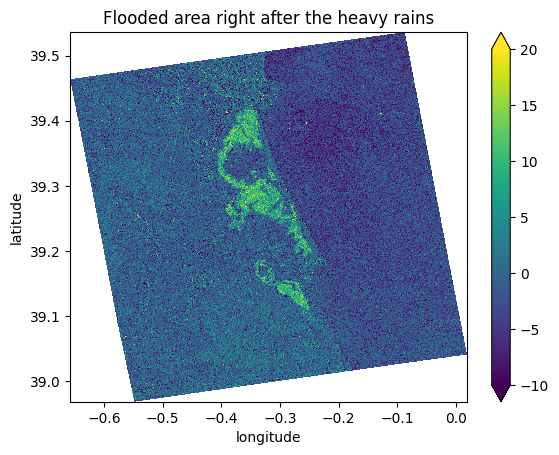

In [32]:
dif = (intensity_data_cube[1]-intensity_data_cube[2])   # computing the difference between third and second dataset
dif.plot(x="longitude", y="latitude", vmin=-10, vmax=20)
plt.title("Flooded area right after the heavy rains")
plt.show()

Taking advantage of the data cube we have created over a new `time` dimension, it is much easier to plot the data over this new dimension, as in a time series plot.<br>
As our data now shares same dimensions and shape, we can choose to plot a backscatter analysis over the specific latitude and longitude point we defined earlier.<br>

As these coordinates might not be exactly the ones shown on the dimension values, we need to perform some operations to find the closest values to the desired coordinates.<br> 
We will now change the latitude and longitude coordinate values and see how the corresponding `azimuth_time` and `ground_range` values and indexes change.

In [ ]:
# Find how far each pixel's latitude and longitude is from the target point
abs_error = np.abs(intensity_data_cube.latitude - TARGET_LAT) + np.abs(intensity_data_cube.longitude - TARGET_LONG)  

# Get the indexes of the closest point
i, j = np.unravel_index(np.argmin(abs_error.values), abs_error.shape)
azimuth_time_index = i
ground_range_index = j

# Get the coordinate values of the closest point
azimuth_time_value = intensity_data_cube.azimuth_time[i].values
ground_range_value = intensity_data_cube.ground_range[j].values

print("Nearest azimuth_time:", azimuth_time_value, ", with index:", azimuth_time_index)
print("Nearest ground_range:", ground_range_value, ", with index:", ground_range_index)

# Slice the data cube in order to get only the pixel that corresponds to the target point
target_point = intensity_data_cube.isel(ground_range=ground_range_index, 
                                        azimuth_time=azimuth_time_index)

Nearest azimuth_time: 2024-10-07T18:03:10.977034725 , with index: 301
Nearest ground_range: 217810.0 , with index: 272


Now we can just plot the data cube, choosing to show backscatter intensity over the target point we defined just before.

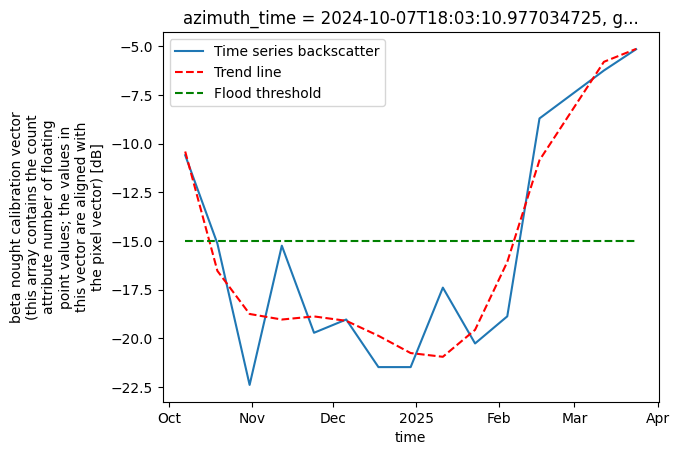

In [35]:
# Plot the sliced data cube
target_point.plot(label='Time series backscatter') 

x = target_point[target_point.dims[0]].values   # getting the x axis values (time)
y = target_point.values                         # getting the y axis values (backscatter intensity)

# Creating the trend line
x_num = np.arange(len(x))   
z = np.polyfit(x_num, y, 6)
p = np.poly1d(z)

plt.plot(x, p(x_num), 'r--', label='Trend line')
plt.plot(x, [-15] * len(x), 'g--', label='Flood threshold')
plt.legend()
plt.show()

<hr>

## Challenges

While using the optimised `.zarr` format saves a lot of time and makes creating workflows relatively simple and achievable, there are still a few challenges to handle and to keep in mind:

- Sentinel-1 GRD Data Availability: For **Sentinel-1 GRD**, most of the datasets are not yet available on the STAC catalogue. This makes searching and data handling harder because, in the end, only a few products are correctly converted.

- Backscatter Computation Libraries: There are only a few working Python libraries that handle backscatter computation. When considering the `.zarr` format, the list becomes even smaller. `xarray_sentinel` is a very good library that handles intensity backscatter computation with `.zarr`.

- Terrain Correction: With the available libraries, it is very difficult to perform geometric and radiometric terrain correction. The existing tools that support the .`zarr` format are not yet fully operational and do not accept the format as it is.

- Image Coregistration: As discussed previously, the .`zarr` format is perfect for handling multiple datasets simultaneously and, thus, for time series analysis. The problem is that there is no library or package that performs **coregistration** of Sentinel images, especially with the `.zarr` format. And it remains a significant problem because **coregistering** multiple Sentinel images is an important step for most SAR workflows.

<hr>

## Conclusion

The .`zarr` format is perfect for analysing these types of hazards because it allows us to load many datasets into a single one (either by creating a data cube or by stacking everything into a list of datatrees). It is, therefore, the ideal tool for rapid, multi-temporal and multi-spatial monitoring. Not only do we not need to download everything (as was required with the .SAFE format), but data handling and any operations are also faster with `.zarr` since only the groups that we need are loaded; everything else is shown on the fly.

Another factor to consider is that, even without having all the necessary libraries to complete the data processing fully, there is always a way to overcome these issues, either by adapting the processing workflow or by adapting existing libraries. With the .SAFE format, it was possible to use SNAP as an application to process everything in a single place. We are not yet at this stage for the `.zarr` format, but we are on the way to achieving that. There are already some promising libraries that are working with `.zarr` and trying to handle the most basic SAR operations, such as `xarray_sentinel` and `sarsen`. It would be a major achievement to consolidate all the capabilities and operations of SNAP into these Python libraries in order to create a Python-based toolbox for processing Sentinel data.

In this use case, the massive Valencia floods were analysed, and it was easy to perceive the extent of the flooding and for how long these areas were under water. Sentinel-1 data is the perfect tool to study flooding events thanks to its water sensitivity backscatter. The workflow used can be easily adapted to other flood monitoring use cases, where variables and constants can be changed according to the environment being studied.